-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from numpy import mean
from numpy import std
import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [29]:
df_input = pd.read_csv('df_combine_20240526.csv')
# round vesicles number
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,0.980,0.370,0.141,0.840,2.400,0.3900,0.062,28,21877.854890,0.020864
1,1.925,1.225,1.300,0.775,1.400,0.6375,0.051,4,1500.110492,0.001431
2,2.400,0.146,0.083,0.740,1.325,0.1650,0.490,68,22278.211604,0.021246
3,1.525,0.960,1.100,0.645,1.250,0.2130,0.460,72,31083.114064,0.029643
4,1.750,1.650,0.014,0.395,2.250,0.5475,0.032,29,13491.373301,0.012866
5,1.450,2.375,0.188,1.475,0.895,0.5100,0.265,46,15498.458308,0.014780
6,2.200,1.025,0.020,0.475,1.675,0.0840,0.142,0,0.000000,0.000000
7,1.975,0.945,1.625,0.139,2.000,0.3675,0.065,2,1732.391999,0.001652
8,1.975,0.575,0.465,0.430,1.700,0.5925,0.450,5,1742.798525,0.001662
9,2.475,2.200,0.605,0.640,0.750,0.0675,0.350,2,615.752160,0.000587


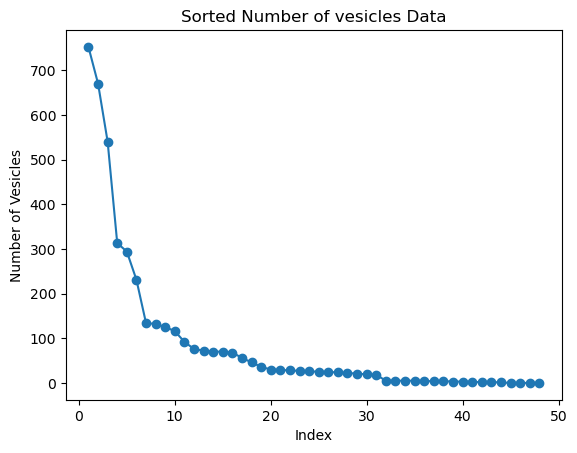

In [30]:
# Sort the DataFrame based on the "area_percent" column
df_sorted = df_input.sort_values(by="num_vesicles", ascending=False)

# Plot the sorted data
plt.plot(range(1, len(df_sorted) + 1), df_sorted["num_vesicles"], marker='o')
plt.xlabel("Index")
plt.ylabel("Number of Vesicles")
plt.title("Sorted Number of vesicles Data")
plt.show()

In [6]:
len(df_input[df_input['num_vesicles']>0])/48
# 92% have vesicles

0.9166666666666666

In [31]:
# Apply log1p transformation to each value in the DataFrame
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_1895/2331498562.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.683097,0.314811,0.131905,0.609766,1.223775,0.329304,0.060154,28
1,1.073294,0.799757,0.832909,0.573800,0.875469,0.493171,0.049742,4
2,1.223775,0.136278,0.079735,0.553885,0.843720,0.152721,0.398776,68
3,0.926241,0.672944,0.741937,0.497740,0.810930,0.193097,0.378436,72
4,1.011601,0.974560,0.013903,0.332894,1.178655,0.436641,0.031499,29
5,0.896088,1.216395,0.172271,0.906240,0.639219,0.412110,0.235072,46
6,1.163151,0.705570,0.019803,0.388658,0.983949,0.080658,0.132781,0
7,1.090244,0.665262,0.965081,0.130151,1.098612,0.312984,0.062975,2
8,1.090244,0.454255,0.381855,0.357674,0.993252,0.465305,0.371564,5
9,1.245594,1.163151,0.473124,0.494696,0.559616,0.065319,0.300105,2


In [8]:
df_input.to_csv('../../data/20240523/df_input_20240526.csv', index=False)

In [32]:
df_input_init = pd.read_csv('../../data/20240517/df_input_update_20240518.csv')

In [33]:
df_input_update = pd.concat([df_input_init, df_input])
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
43,0.033435,1.193922,0.965081,0.788457,1.038508,0.106610,0.227136,125
44,0.955511,1.216395,0.993252,0.527683,0.717840,0.296394,0.190620,70
45,0.729961,1.178655,0.021761,0.536493,0.926241,0.323893,0.402126,313
46,0.015873,0.106160,0.476234,1.056053,1.178655,0.345361,0.143234,92


In [34]:
df_input_update.to_csv('../../data/20240523/df_input_update_20240526.csv', index = False)

In [2]:
df_input_update= pd.read_csv('../../data/20240523/df_input_update_20240526.csv')

In [3]:
# Input for classification model
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
187,0.033435,1.193922,0.965081,0.788457,1.038508,0.106610,0.227136,1
188,0.955511,1.216395,0.993252,0.527683,0.717840,0.296394,0.190620,1
189,0.729961,1.178655,0.021761,0.536493,0.926241,0.323893,0.402126,1
190,0.015873,0.106160,0.476234,1.056053,1.178655,0.345361,0.143234,1


In [4]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

Iteration 1: Training Accuracy = 0.8824, Test Accuracy = 0.7692
Iteration 2: Training Accuracy = 0.9085, Test Accuracy = 0.7692
Iteration 3: Training Accuracy = 0.8693, Test Accuracy = 0.8718
Iteration 4: Training Accuracy = 0.8693, Test Accuracy = 0.9231
Iteration 5: Training Accuracy = 0.9020, Test Accuracy = 0.8718
Iteration 6: Training Accuracy = 0.9412, Test Accuracy = 0.7949
Iteration 7: Training Accuracy = 0.9281, Test Accuracy = 0.7949
Iteration 8: Training Accuracy = 0.8693, Test Accuracy = 0.8205
Iteration 9: Training Accuracy = 0.8824, Test Accuracy = 0.8462
Iteration 10: Training Accuracy = 0.8758, Test Accuracy = 0.8462

Average Training Accuracy over 10 runs: 0.8928
Average Test Accuracy over 10 runs: 0.8308


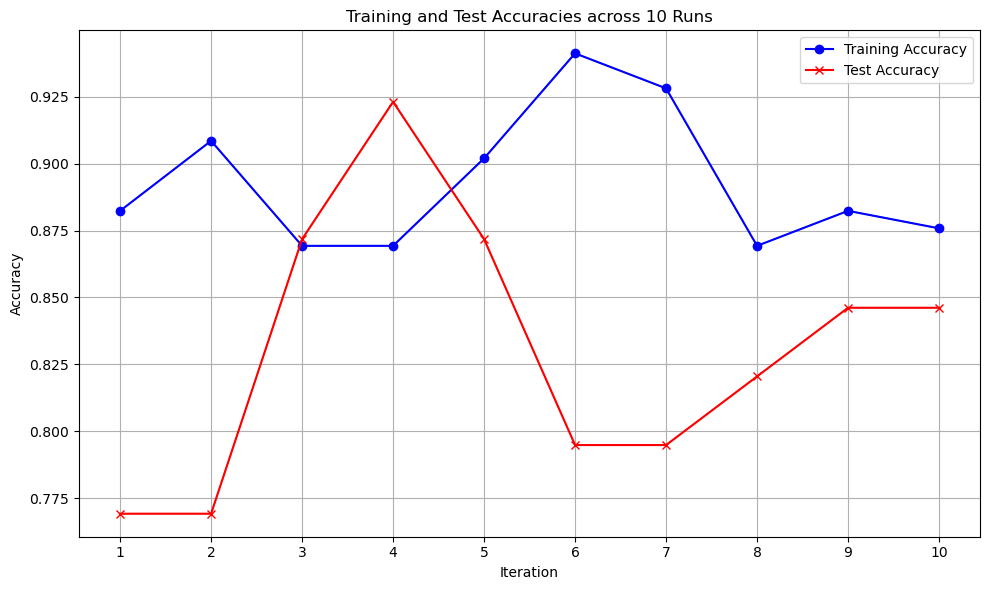

In [16]:

train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies)
avg_test_accuracy = np.mean(test_accuracies)

print(f"\nAverage Training Accuracy over 10 runs: {avg_train_accuracy:.4f}")
print(f"Average Test Accuracy over 10 runs: {avg_test_accuracy:.4f}")


# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Iteration 1: Training Accuracy = 0.8824, Test Accuracy = 0.7692
Iteration 2: Training Accuracy = 0.9085, Test Accuracy = 0.7692
Iteration 3: Training Accuracy = 0.8693, Test Accuracy = 0.8718
Iteration 4: Training Accuracy = 0.8693, Test Accuracy = 0.9231
Iteration 5: Training Accuracy = 0.9020, Test Accuracy = 0.8718
Iteration 6: Training Accuracy = 0.9412, Test Accuracy = 0.7949
Iteration 7: Training Accuracy = 0.9281, Test Accuracy = 0.7949
Iteration 8: Training Accuracy = 0.8693, Test Accuracy = 0.8205
Iteration 9: Training Accuracy = 0.8824, Test Accuracy = 0.8462
Iteration 10: Training Accuracy = 0.8758, Test Accuracy = 0.8462

Average Training Accuracy: 0.8928
Training Accuracy Standard Deviation: 0.0247
Average Test Accuracy: 0.8308
Test Accuracy Standard Deviation: 0.0476


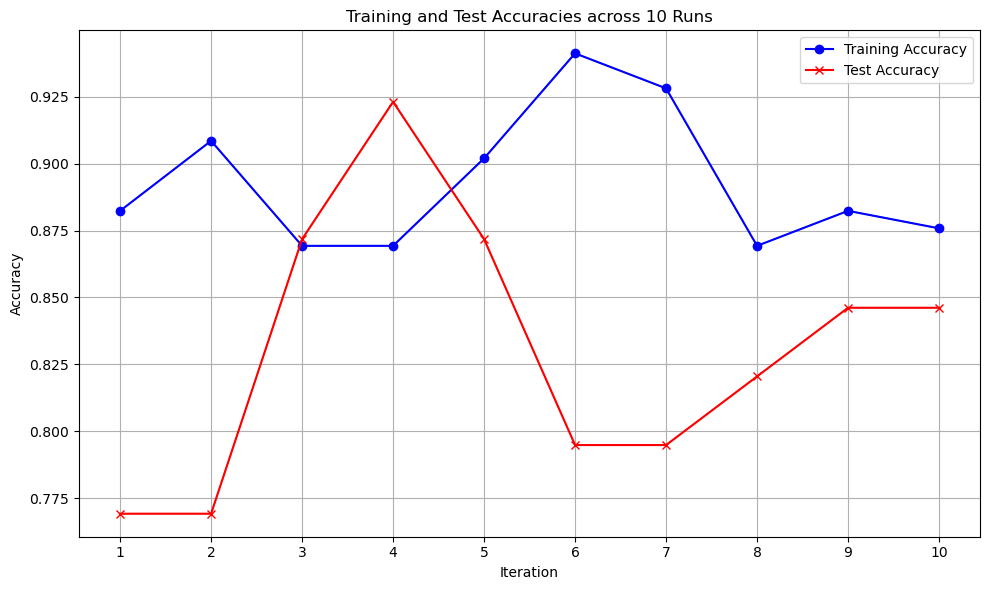

In [5]:
# Showing std for repeated runs
train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Add the src directory to sys.path
import sys
sys.path.append(os.path.abspath('../src'))

In [22]:
# working on whole dagtaset to get final model
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)

model.score(X, y)

0.875

In [23]:
# Save the model to a file
with open('../../data/20240523/model/GPC_model_20240526.pkl', 'wb') as file:
    pickle.dump(model, file)

In [2]:
# Load the model from the file
with open('../../data/20240523/model/GPC_model_20240526.pkl', 'rb') as file:
    model = pickle.load(file)

In [3]:
model.kernel_.get_params()

{'k1': 5.22**2,
 'k2': RBF(length_scale=2.1),
 'k1__constant_value': 27.245044600856268,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 2.1031118029259597,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [123]:
# Reduce input space with constraints

In [13]:
df_input_update= pd.read_csv('df_input_update_20240526.csv')

In [19]:
original_bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1., 1.]])

# Sample points in the 7-dimensional space until we get the required number of valid samples
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]
valid_samples = torch.empty((0, num_dimensions))

while len(valid_samples) < num_required_samples:
    # Generate random samples in the original space
    samples = torch.rand(num_required_samples, num_dimensions)  

    # Scale the samples to the specified original bounds
    scaled_samples = samples * (original_bounds[1] - original_bounds[0]) + original_bounds[0]

    # Apply the constraint: sum of 7 features must be less than m1
    valid_samples_batch = scaled_samples[scaled_samples.sum(dim=1) < median_value]

    # Append valid samples to the tensor
    valid_samples = torch.cat((valid_samples, valid_samples_batch), dim=0)

    # Truncate the tensor to the required number of samples if it exceeds
    if len(valid_samples) > num_required_samples:
        valid_samples = valid_samples[:num_required_samples]

# Apply log1p transform to the valid samples
valid_samples = torch.log1p(valid_samples)

# Now valid_samples contains the required number of sampled points within the specified bounds and satisfying the constraint
print(valid_samples.shape)  # Should print: torch.Size([10000000, 7])

torch.Size([10000000, 7])


(array([1.990000e+02, 3.485000e+03, 2.763900e+04, 1.348120e+05,
        4.442580e+05, 1.057382e+06, 1.883229e+06, 2.523628e+06,
        2.554839e+06, 1.370529e+06]),
 array([0.35352516, 0.64874578, 0.94396639, 1.239187  , 1.53440762,
        1.82962823, 2.12484884, 2.42006946, 2.71529007, 3.01051068,
        3.3057313 ]),
 <BarContainer object of 10 artists>)

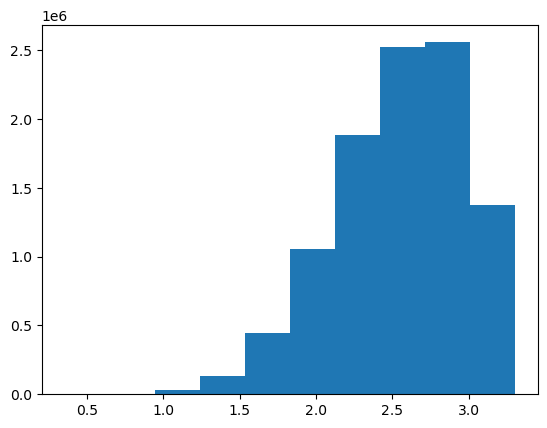

In [177]:
plt.hist(valid_samples.sum(axis=1))

In [20]:
df_sample = pd.DataFrame(valid_samples, columns=[df_input_update.iloc[:,0:7].columns])

In [21]:
start_time = time.time()

# Your code snippet
pred_prob = model.predict_proba(df_sample.values)

# Record end time
end_time = time.time()

# Calculate running time
running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 481.05166888237 seconds


In [22]:
entropy_value = cal_entropy(pred_prob)
# Get indices of the first 48 samples with highest entropy
top_indices = np.argsort(entropy_value)[::-1][:48]
top_indices

array([5650768, 1185688, 3894094, 2313609, 1793133, 4750406, 4814063,
       6434551, 2357807, 4932205, 1457218, 7792627, 8928913,   84883,
       4931817, 3126037, 1537314, 7893375,  785056, 3940627,   32697,
       6787045, 1930571, 8098217, 9417595,  393420,  420080, 7298714,
       8667144, 7226308, 2602869, 2246165, 3532328, 3230114, 7375153,
       6973169, 7879632, 5378913,  757839, 2389133, 7586318, 2570070,
       1053324, 5033235, 5761926, 6387982, 8930028,  809897])

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

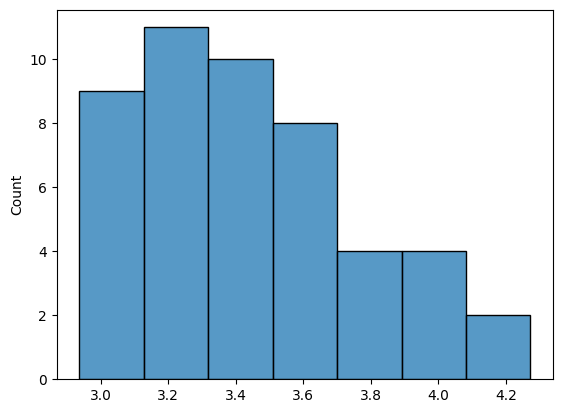

In [23]:
sns.histplot(df_sample.iloc[top_indices].iloc[:,:].sum(axis=1))

In [24]:
df_sample.to_csv('df_sample_20240528.csv', index=False)
df_prob = pd.DataFrame(pred_prob)
df_prob.to_csv('pred_prob_20240528.csv', index=False)
# overwrite df_sample_20240520

In [26]:
candidates = df_sample.iloc[top_indices]
original_scale_df = np.expm1(candidates)
original_scale_df

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
5650768,0.461276,0.417760,0.996559,0.961490,0.944568,0.303260,0.793759
1185688,0.815873,0.719365,0.866729,0.846917,0.924058,0.188321,0.225960
3894094,0.853757,0.397801,0.992414,0.931841,0.834709,0.249171,0.569870
2313609,0.719694,0.553363,0.541164,0.799392,0.876613,0.119320,0.682687
1793133,0.787391,0.044352,0.900774,0.874186,0.780435,0.055048,0.858242
4750406,0.712628,0.999073,0.563688,0.920006,0.611312,0.124021,0.978450
4814063,0.778981,0.359338,0.893871,0.870846,0.863281,0.341281,0.973206
6434551,0.602863,0.765877,0.334267,0.867218,0.970823,0.270718,0.786201
2357807,0.548256,0.907873,0.669632,0.587438,0.909746,0.053725,0.882511
4932205,0.469593,0.342249,0.789285,0.992955,0.870436,0.028749,0.423530


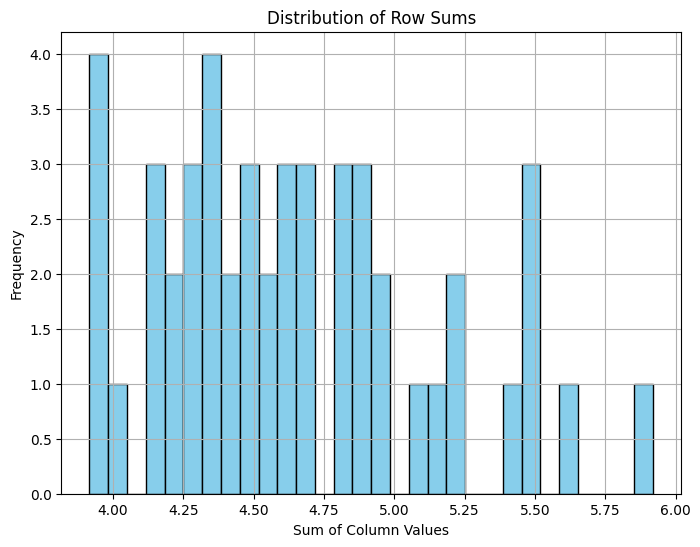

In [27]:
row_sums = original_scale_df.sum(axis=1)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(row_sums, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Row Sums')
plt.xlabel('Sum of Column Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [28]:
candidates.to_csv('candidates_20240528.csv', index = False)

In [40]:
df_input_update.to_csv('df_input_update_plot_20240526.csv', index=False)

In [118]:
df_input_update=pd.read_csv('df_input_update_plot_20240526.csv')

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

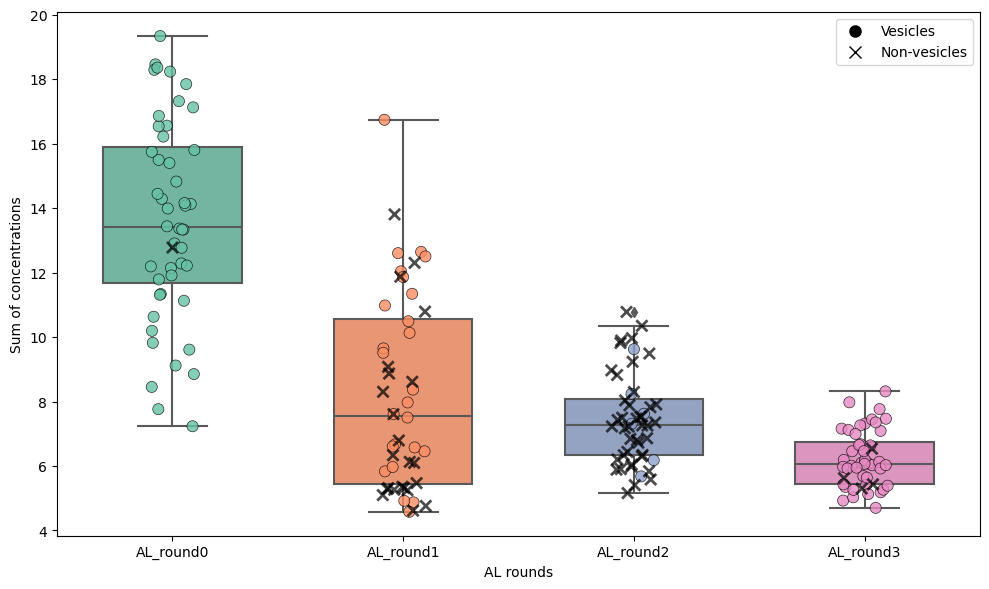

In [119]:
# Define the columns to be transformed back
columns_to_transform = df_input_update.columns[:7]

# Apply the inverse log1p transformation
df_input_update[columns_to_transform] = np.expm1(df_input_update[columns_to_transform])

# Calculate the sum of the first 7 columns for each row
df_input_update['sum'] = df_input_update.iloc[:, :7].sum(axis=1)

# Split the DataFrame into 3 groups of 48 rows and add a 'group' column
group_labels = np.repeat([1, 2, 3, 4], 48)
df_input_update['group'] = group_labels[:len(df_input_update)]

# Separate data for vesicles and non-vesicles
vesicles = df_input_update[df_input_update['num_vesicles'] == 1]
non_vesicles = df_input_update[df_input_update['num_vesicles'] == 0]

# Initialize the figure
plt.figure(figsize=(10, 6))

# Create a box plot with Seaborn
sns.boxplot(x='group', y='sum', data=df_input_update, palette='Set2', color='white', width=0.6)

# Overlay a scatter plot for vesicles
sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.8)

# Overlay a scatter plot for non-vesicles with a thick line
sns.stripplot(x='group', y='sum', data=non_vesicles, palette='Set2', marker='x', size=8, edgecolor='black', linewidth=2, alpha=0.7)

# Add labels and title
plt.xlabel('AL rounds')
plt.ylabel('Sum of concentrations')
plt.xticks(ticks=[0, 1, 2, 3], labels=['AL_round0', 'AL_round1', 'AL_round2', 'AL_round3'])

# Add custom legend
import matplotlib.lines as mlines

vesicles_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Vesicles')
non_vesicles_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Non-vesicles')

plt.legend(handles=[vesicles_legend, non_vesicles_legend])

# Show the plot
plt.tight_layout()
plt.show()


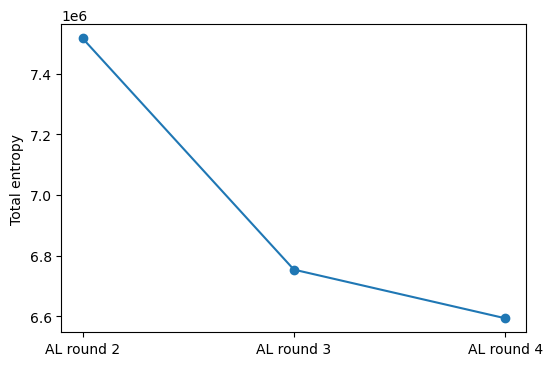

In [51]:
p1 = 7516738.705192391
p2 = 6753653.153610267
p3 = 6593180.39466389
p = [p1, p2, p3]

# Plot the trend
plt.figure(figsize=(6, 4))
plt.plot(p, marker='o')

# Add labels and title
# plt.xlabel('AL round')
plt.ylabel('Total entropy')
plt.xticks([0, 1, 2], ['AL round 2', 'AL round 3', 'AL round 4'])  # Label the x-axis ticks
plt.show()

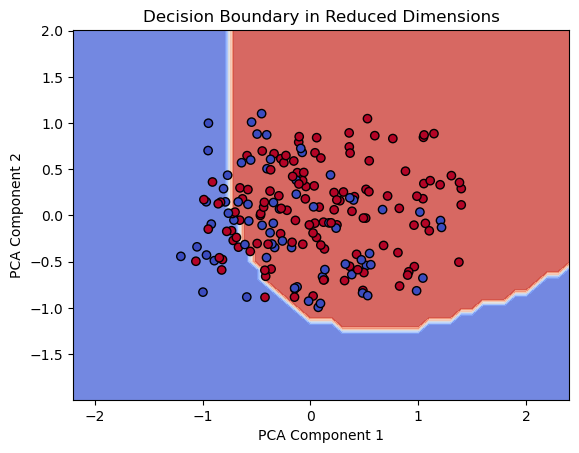

In [66]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
plt.show()


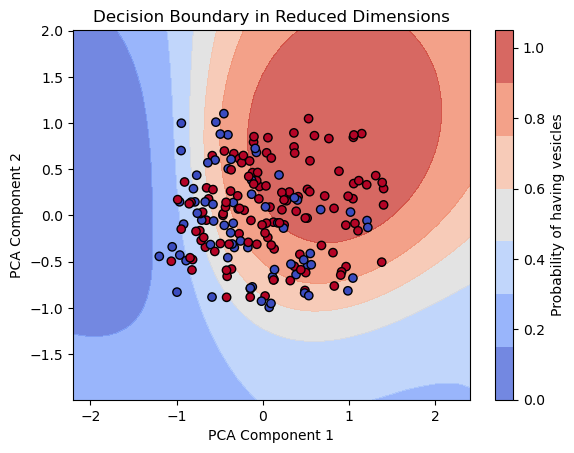

In [63]:
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
probs = model.predict_proba(grid_points_original_space)
probs_class_1 = probs[:, 1].reshape(xx.shape)

# Plot decision boundary and data points
contour = plt.contourf(xx, yy, probs_class_1, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
# Add color bar
cbar = plt.colorbar(contour)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

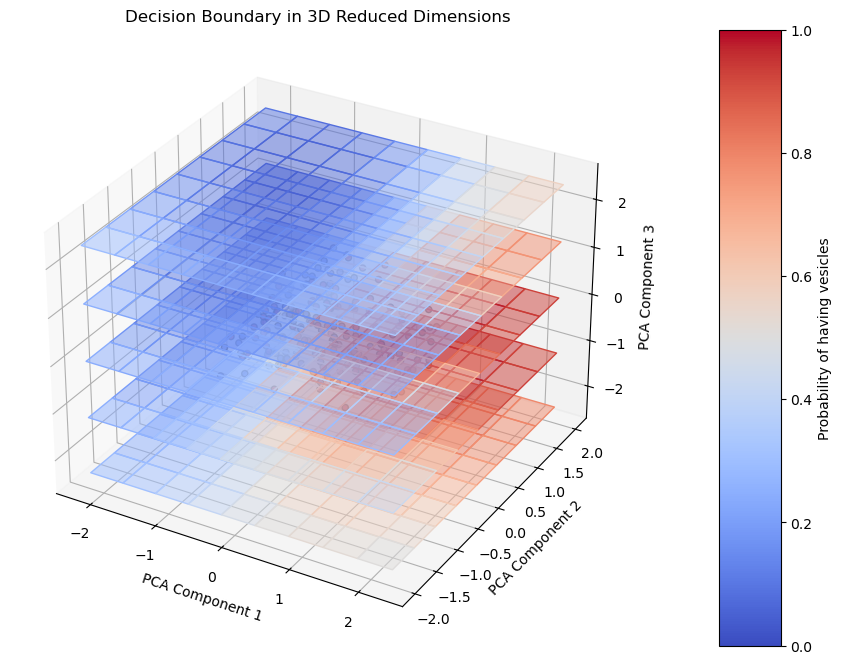

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Fit PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
z_min, z_max = X_reduced[:, 2].min() - 1, X_reduced[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot slices of the decision boundary at different z levels
z_levels = np.linspace(z_min, z_max, num=5)
norm = Normalize(vmin=0, vmax=1)

for z in z_levels:
    zz = np.full_like(xx, z)
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    grid_points_original_space = pca.inverse_transform(grid_points)
    probs = model.predict_proba(grid_points_original_space)
    probs_class_1 = probs[:, 1].reshape(xx.shape)
    
    # Plot the surface for this z slice
    surf = ax.plot_surface(xx, yy, zz, facecolors=plt.cm.coolwarm(norm(probs_class_1)), alpha=0.5, shade=False)
    
# Plot the data points
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Decision Boundary in 3D Reduced Dimensions')

# Add color bar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, aspect=10)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [89]:
pca = PCA()
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.29323965, 0.18914477, 0.17690126, 0.15542134, 0.11781494,
       0.0496297 , 0.01784834])

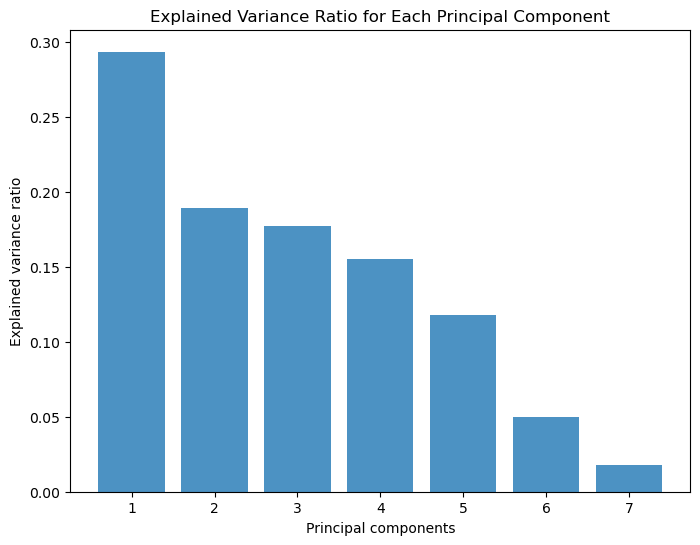

In [90]:
%matplotlib inline
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio for each PC
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

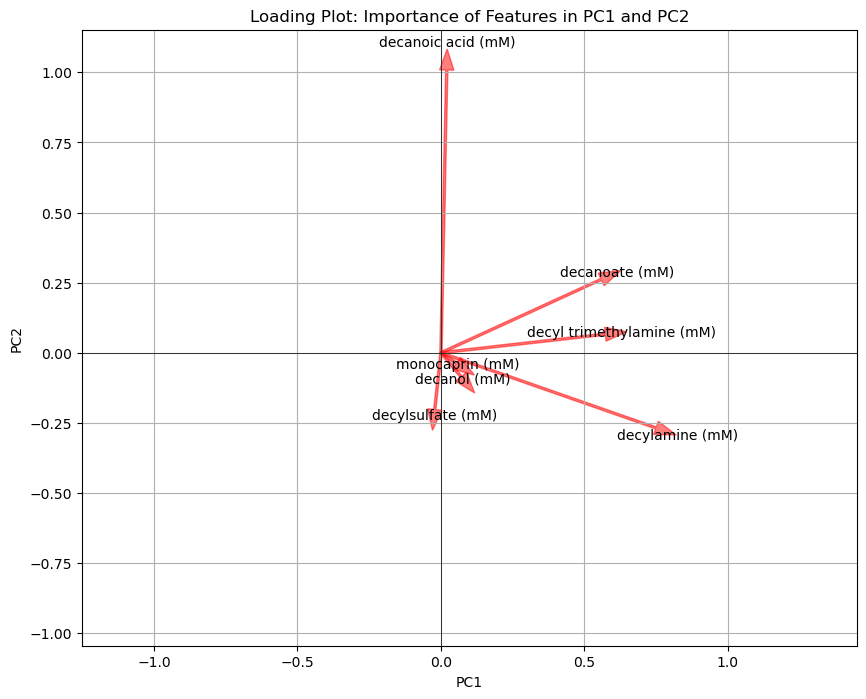

In [105]:
# Get the loadings for the first two PCs
loadings = pca.components_[:2, :]

# Feature names
feature_names = ['decanoic acid (mM)', 'decanoate (mM)',
                 'decylamine (mM)', 'decyl trimethylamine (mM)',
                 'decylsulfate (mM)', 'decanol (mM)',
                 'monocaprin (mM)']

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)

# Plot loadings with arrows
plt.figure(figsize=(10, 8))
plt.title('Loading Plot: Importance of Features in PC1 and PC2')

# Scale factor for the arrows to make them visually appealing
scale_factor = 1.1

for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * scale_factor, loadings_df.loc[feature, 'PC2'] * scale_factor,
              color='r', alpha=0.5, width=0.008, head_width=0.05)
    plt.text(loadings_df.loc[feature, 'PC1'] * scale_factor * 1.1, loadings_df.loc[feature, 'PC2'] * scale_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Set x and y limits based on PC1 and PC2 range
pc1_min, pc1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
pc2_min, pc2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
plt.xlim(pc1_min - 0.05, pc1_max + 0.05)
plt.ylim(pc2_min - 0.05, pc2_max + 0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

### Create dispense volume

In [29]:
original_scale_df.to_csv('original_scale_df_GPC_20240528.csv', index=False)

(array([5., 8., 9., 8., 6., 3., 3., 4., 1., 1.]),
 array([3.91679764, 4.11711502, 4.3174324 , 4.51774931, 4.71806669,
        4.91838408, 5.11870146, 5.31901884, 5.51933575, 5.71965313,
        5.91997051]),
 <BarContainer object of 10 artists>)

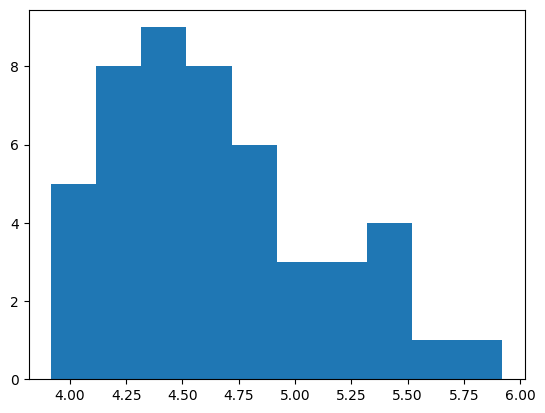

In [30]:
plt.hist(original_scale_df.sum(axis=1))

In [35]:
original_scale_df

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
5650768,0.461276,0.417760,0.996559,0.961490,0.944568,0.303260,0.793759
1185688,0.815873,0.719365,0.866729,0.846917,0.924058,0.188321,0.225960
3894094,0.853757,0.397801,0.992414,0.931841,0.834709,0.249171,0.569870
2313609,0.719694,0.553363,0.541164,0.799392,0.876613,0.119320,0.682687
1793133,0.787391,0.044352,0.900774,0.874186,0.780435,0.055048,0.858242
4750406,0.712628,0.999073,0.563688,0.920006,0.611312,0.124021,0.978450
4814063,0.778981,0.359338,0.893871,0.870846,0.863281,0.341281,0.973206
6434551,0.602863,0.765877,0.334267,0.867218,0.970823,0.270718,0.786201
2357807,0.548256,0.907873,0.669632,0.587438,0.909746,0.053725,0.882511
4932205,0.469593,0.342249,0.789285,0.992955,0.870436,0.028749,0.423530


In [36]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=True)
len(dispense_df)

48

In [38]:
def clean_column_name(name):
    return name.replace("('", "").replace("_Concentration (mM)',) ", "_Concentration ")

# Apply the function to the column names
dispense_df.columns = [clean_column_name(col) for col in dispense_df.columns]
dispense_df.columns

Index(['decanoic acid_Concentration (50 mM)',
       'decanoic acid_Concentration (10 mM)',
       'decanoic acid_Concentration (2 mM)', 'decanoate_Concentration (50 mM)',
       'decanoate_Concentration (10 mM)', 'decanoate_Concentration (2 mM)',
       'decylamine_Concentration (50 mM)', 'decylamine_Concentration (10 mM)',
       'decylamine_Concentration (2 mM)',
       'decyl trimethylamine_Concentration (50 mM)',
       'decyl trimethylamine_Concentration (10 mM)',
       'decyl trimethylamine_Concentration (2 mM)',
       'decylsulfate_Concentration (50 mM)',
       'decylsulfate_Concentration (10 mM)',
       'decylsulfate_Concentration (2 mM)', 'decanol_Concentration (15 mM)',
       'decanol_Concentration (3 mM)', 'monocaprin_Concentration (10 mM)',
       'monocaprin_Concentration (2 mM)'],
      dtype='object')

In [40]:
dispense_df.to_csv('dispense_df_GPC_20240528.csv', index=False)

In [42]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240523/dispense_df_20240528.xlsx') as writer:
    # Write df_repeated to sheet Plate1
    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_repeated to sheet Plate2
    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)

In [39]:
dispense_df

,decanoic acid_Concentration (50 mM),decanoic acid_Concentration (10 mM),decanoic acid_Concentration (2 mM),decanoate_Concentration (50 mM),decanoate_Concentration (10 mM),decanoate_Concentration (2 mM),decylamine_Concentration (50 mM),decylamine_Concentration (10 mM),decylamine_Concentration (2 mM),decyl trimethylamine_Concentration (50 mM),decyl trimethylamine_Concentration (10 mM),decyl trimethylamine_Concentration (2 mM),decylsulfate_Concentration (50 mM),decylsulfate_Concentration (10 mM),decylsulfate_Concentration (2 mM),decanol_Concentration (15 mM),decanol_Concentration (3 mM),monocaprin_Concentration (10 mM),monocaprin_Concentration (2 mM)
5650768,0.0,9.2,0.0,0.0,8.4,0.0,0.0,19.9,0.0,0.0,19.2,0.0,0.0,18.9,0.0,4.0,0.0,15.9,0.0
1185688,0.0,16.3,0.0,0.0,14.4,0.0,0.0,17.3,0.0,0.0,16.9,0.0,0.0,18.5,0.0,0.0,12.6,4.5,0.0
3894094,0.0,17.1,0.0,0.0,8.0,0.0,0.0,19.8,0.0,0.0,18.6,0.0,0.0,16.7,0.0,0.0,16.6,11.4,0.0
2313609,0.0,14.4,0.0,0.0,11.1,0.0,0.0,10.8,0.0,0.0,16.0,0.0,0.0,17.5,0.0,0.0,8.0,13.7,0.0
1793133,0.0,15.7,0.0,0.0,0.0,4.4,0.0,18.0,0.0,0.0,17.5,0.0,0.0,15.6,0.0,0.0,3.7,17.2,0.0
4750406,0.0,14.3,0.0,0.0,20.0,0.0,0.0,11.3,0.0,0.0,18.4,0.0,0.0,12.2,0.0,0.0,8.3,19.6,0.0
4814063,0.0,15.6,0.0,0.0,7.2,0.0,0.0,17.9,0.0,0.0,17.4,0.0,0.0,17.3,0.0,4.6,0.0,19.5,0.0
6434551,0.0,12.1,0.0,0.0,15.3,0.0,0.0,6.7,0.0,0.0,17.3,0.0,0.0,19.4,0.0,0.0,18.0,15.7,0.0
2357807,0.0,11.0,0.0,0.0,18.2,0.0,0.0,13.4,0.0,0.0,11.7,0.0,0.0,18.2,0.0,0.0,3.6,17.7,0.0
4932205,0.0,9.4,0.0,0.0,6.8,0.0,0.0,15.8,0.0,0.0,19.9,0.0,0.0,17.4,0.0,0.0,1.9,8.5,0.0
